In [1]:
%load_ext autoreload
%autoreload 2
import sound_field_creation
from optimizer import optimizer
import utils
from tqdm import tqdm
import numpy as np
import multiprocessing as mp
import math
import time
import torch
LEBEDEV = 'lebedev'
POINTS_162 = '162_points'
SQP_OPT_METHOD = "SQP"
GD_OPT_METHOD = "GD_lagrange_multi"
SLS_OPT_METHOD = "SLS"
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_grad_enabled(False)




In [2]:
signals = [
    sound_field_creation.signal_info(
        name="male", signal_path=r"data/sound_files/male_speech.wav", th=90, ph=90,in_rad=False,device = DEVICE
    ),
    sound_field_creation.signal_info(
        name="female", signal_path=r"data/sound_files/female_speech.wav", th=90, ph=45,in_rad=False,device=DEVICE
    ),
]

### Encode Sound Field

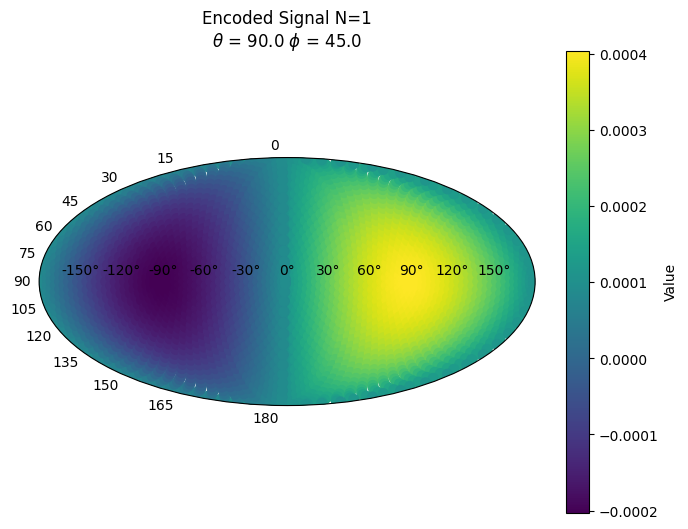

In [ ]:
sound_field = sound_field_creation.sound_field(DEVICE)
input_order = 1
anm_t = sound_field.create(
    signals=signals,
    order=input_order,
    debug=True,
    grid_type=LEBEDEV,
    device=DEVICE,
)

### Divide to Subbands

In [ ]:
down_sample = 2
num_bins = 45
anm_t_subbands = sound_field.divide_to_subbands(
    num_bins=num_bins, downsample=down_sample
)
print(anm_t_subbands.shape)
print(f"{anm_t_subbands.is_cuda=}")

torch.Size([45, 68185, 4])


### Divide to Windows

In [27]:
window_length = 1024
max_num_windows = 30
anm_t_windowed = sound_field.divide_to_time_windows(
    window_length=window_length, max_num_windows=int(max_num_windows)
)
print(anm_t_windowed.shape)
print(f"{anm_t_windowed.is_cuda=}")

torch.Size([30, 45, 1024, 4])
anm_t_windowed.is_cuda=False


### Create Mask


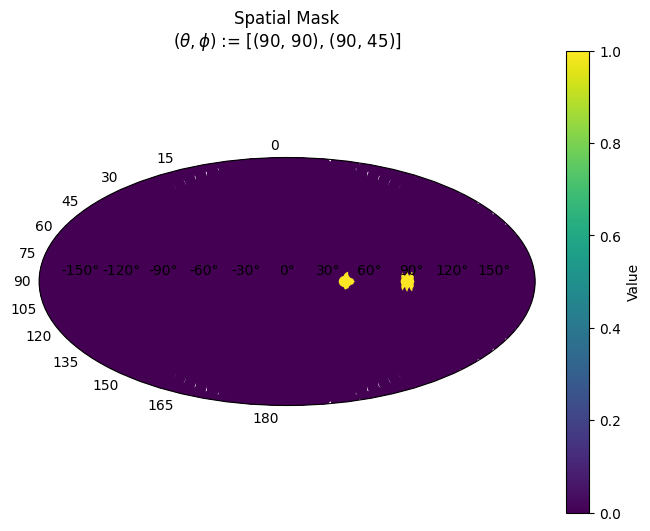

In [19]:
mask_type = 'cheat' # "cheat" None , 'algo'

if mask_type is None:
    mask = None
else:
    if mask_type == "cheat":
        target_th = torch.tensor([math.radians(coo[0]) for coo in sound_field.sources_coords])
        target_ph = torch.tensor([math.radians(coo[1]) for coo in sound_field.sources_coords])
        mask = torch.any(torch.sqrt((sound_field.P_th[...,None] - target_th)**2 + (sound_field.P_ph[...,None] - target_ph)**2) < math.radians(5),dim=1)
    elif mask_type == "algo":
        pass
    dummy = torch.zeros_like(mask)
    dummy[mask] = 1
    utils.plot_on_2D(
        azi=sound_field.P_ph,
        zen=sound_field.P_th,
        values=dummy,
        title=f"Spatial Mask\n$(\\theta,\\phi)$ := {[tuple((round(th),round(phi))) for (th,phi) in sound_field.sources_coords]}",
    )


### Find Sparse Dict
10 Windows | Lebedev | MP | 45 Freq Bands | 2 Sources | No Mask : 1139s \
30 Windows | Lebedev | MP | 45 Freq Bands | 2 Sources | No Mask: 3496a \
10 Windows | Lebedev | MP | 1 Freq Bands | 2 Sources | No Mask:  33s \
30 Windows | Lebedev | MP | 1 Freq Bands | 2 Sources | No Mask:  70s 

In [25]:
Y_p = utils.create_sh_matrix(input_order, zen=sound_field.P_th, azi=sound_field.P_ph).to(DEVICE)
opt = optimizer(Y_p, alpha=1, method=GD_OPT_METHOD,device=DEVICE)
start = time.time()
with torch.no_grad():
    anm_t_subbands_dict = sound_field.get_sparse_dict_v2(opt,mask,multi_processing=False) #single processing progress bar doesnt work
print(f"Time: {time.time()-start}")

  0%|          | 0/5 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "_pydevd_bundle\\pydevd_cython.pyx", line 1610, in _pydevd_bundle.pydevd_cython.handle_exception
  File "c:\Users\owner\Documents\Repos\AmbisonicUpscaling\.venv\Lib\site-packages\debugpy\_vendored\pydevd\pydevd.py", line 2197, in do_wait_suspend
    keep_suspended = self._do_wait_suspend(thread, frame, event, arg, trace_suspend_type, from_this_thread, frames_tracker)
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\owner\Documents\Repos\AmbisonicUpscaling\.venv\Lib\site-packages\debugpy\_vendored\pydevd\pydevd.py", line 2266, in _do_wait_suspend
    notify_event.wait(wait_timeout)
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\threading.py", line 629, in wait
    signaled = self._cond.wait(timeout)
               ^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Program

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

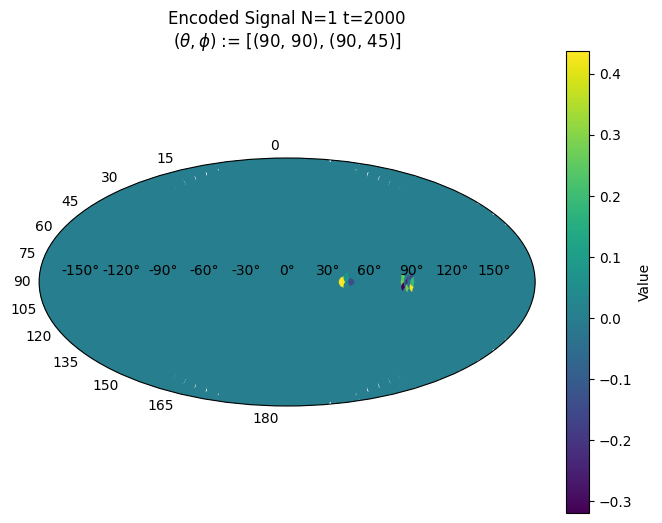

In [ ]:
sound_field.plot_sparse_dict(2000)